<a href="https://colab.research.google.com/github/GergelyTuri/fiberphotometry/blob/main/notebooks/pcb_experiments/signal_analysis_AT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tdt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 1.2 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from tdt import read_block
from datetime import datetime
from scipy.stats import zscore
from datetime import datetime
matplotlib.rcParams['font.size'] = 18 # set font size for all figures

from tdt import read_block, download_demo_data, StructType
%config Completer.use_jedi = False

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
saline_path ="/gdrive/Shareddrives/Turi_lab/Data/psilocybin_project/PCB_Serotonin/drug_experiment-240625-124323/nia_2-240628-133011"
pcb_path ="/gdrive/Shareddrives/Turi_lab/Data/psilocybin_project/PCB_Serotonin/drug_experiment-240625-124323/nia_2-240701-094343"

In [ ]:

saline = read_block(saline_path)
pcb = read_block(pcb_path)


Found Synapse note file: /gdrive/Shareddrives/Turi_lab/Data/psilocybin_project/PCB_Serotonin/drug_experiment-240625-124323/nia_2-240628-133011/Notes.txt
read from t=0s to t=2728.21s
Found Synapse note file: /gdrive/Shareddrives/Turi_lab/Data/psilocybin_project/PCB_Serotonin/drug_experiment-240625-124323/nia_2-240701-094343/Notes.txt
read from t=0s to t=4998.75s


In [ ]:
serotonin = '_465A' # serotonin channel
ISOS = '_405A' # Isosbestic channel
LICK = 'Ler_'

In [ ]:
# Access the 465 and 405 data from the streams attribute #saline

x1 = saline['streams']['_465A'].data  # 465 data
x2 = saline['streams']['_405A'].data  # 405 data

# Polynomial fitting
reg = np.polyfit(x2, x1, 1)

# Conditional assignment for f0
if reg[0] < 0:
    f0 = np.mean(x1)  # rare case
else:
    f0 = reg[0] * x2 + reg[1]  # normal case

# Calculate delF
delF = 100 * (x1 - f0) / f0

# If you need to convert delF to a DataFrame or save it to a file, you can do so
delF_df = pd.DataFrame(delF, columns=['delF'])

# Example: Saving delF to a CSV file
delF_df.to_csv('delF_output.csv', index=False)

# Print delF values
print(delF)

<ipython-input-22-7b8e59d24050>:6: RankWarning: Polyfit may be poorly conditioned
  reg = np.polyfit(x2, x1, 1)


[-99.17544  -99.23874  -99.30896  ...   9.49011    9.503549   9.517156]


In [ ]:
# Access the 465 and 405 data from the streams attribute # pcb

x1 = pcb['streams']['_465A'].data  # 465 data
x2 = pcb['streams']['_405A'].data  # 405 data

# Polynomial fitting
reg = np.polyfit(x2, x1, 1)

# Conditional assignment for f0
if reg[0] < 0:
    f0 = np.mean(x1)  # rare case
else:
    f0 = reg[0] * x2 + reg[1]  # normal case

# Calculate delF
delF = 100 * (x1 - f0) / f0

# If you need to convert delF to a DataFrame or save it to a file, you can do so
delF_df = pd.DataFrame(delF, columns=['delF'])

# Example: Saving delF to a CSV file
delF_df.to_csv('delF_output.csv', index=False)

# Print delF values
print(delF)

<ipython-input-26-b0b2f763ec8c>:6: RankWarning: Polyfit may be poorly conditioned
  reg = np.polyfit(x2, x1, 1)


[-98.47518   -98.47558   -98.485214  ...  -3.0788646  -3.0842085
  -3.0868766]


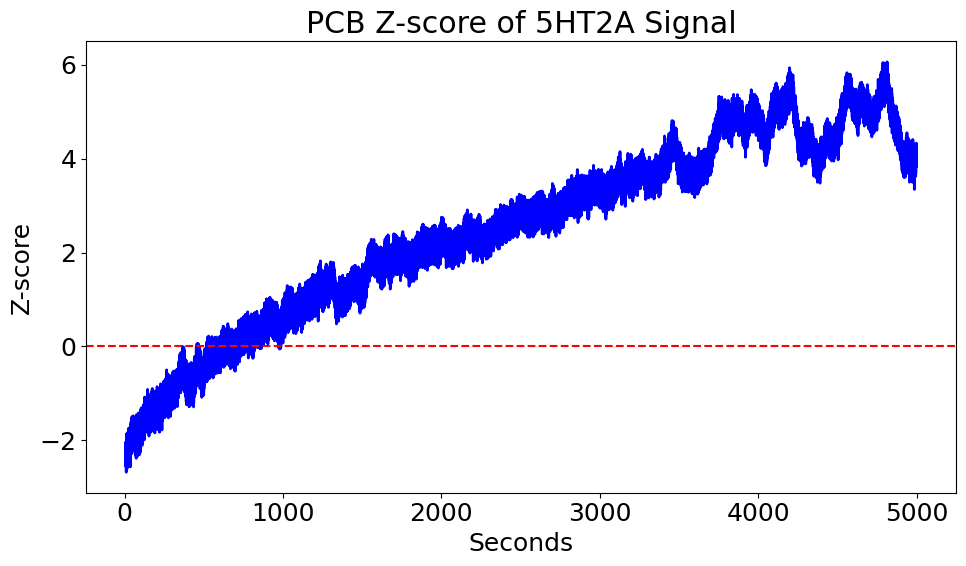

In [ ]:

# Subtract the ISOS signal from the serotonin signal
corrected_signal = delF - pcb.streams[ISOS].data
# Define experiment start time and baseline end time
start_time_str = '9:43:48am'
bline_end_str = '10:08:34am'

# Parse the time strings without date
start_time = datetime.strptime(start_time_str, '%I:%M:%S%p')
bline_end_time = datetime.strptime(bline_end_str, '%I:%M:%S%p')

# Convert baseline end time to seconds relative to start time
bline_end_sec = (bline_end_time - start_time).total_seconds()

# Prepare the time axis for serotonin data
npts = len(pcb.streams[serotonin].data)
time_x = np.linspace(1, npts, npts) / pcb.streams[serotonin].fs
# Artifact removal
t = 8
inds = np.where(time_x > t)
ind = inds[0][0]
time_x = time_x[ind:]  # go from ind to final index
corrected_signal = corrected_signal[ind:]

# # Calculate the z-score
# zscore_signal = zscore(corrected_signal)

# Correct baseline index for trimmed data
baseline_end_idx = np.where(time_x > (bline_end_sec - t))[0][0]
baseline_mean = np.mean(corrected_signal[:baseline_end_idx])
baseline_sd = np.std(corrected_signal[:baseline_end_idx])
zscore_signal = (corrected_signal - baseline_mean) / baseline_sd
# Plot the z-score of the corrected pcb signal
fig2, ax1 = plt.subplots(figsize=(10, 6))
p2, = ax1.plot(time_x, zscore_signal, linewidth=2, color='blue', label='Z-score (serotonin - ISOS)')

# Mark the baseline with a horizontal line on the z-score plot
baseline_zscore = np.mean(zscore_signal[:baseline_end_idx])
ax1.axhline(y=baseline_zscore, color='red', linestyle='--', label='Baseline')

ax1.set_ylabel('Z-score')
ax1.set_xlabel('Seconds')
ax1.set_title('PCB Z-score of 5HT2A Signal')

fig2.tight_layout()

plt.show()

# Create DataFrame for serotonin data
zscore_signal = pd.DataFrame({'Time (s)': time_x, 'Z-score': zscore_signal})
# Save to CSV
zscore_signal.to_csv('/gdrive/Shareddrives/Turi_lab/DeepLabCut/DLC_model_training/fiberphotometry/serotonin_fiberphotometry/serotonin_df.csv', index=False)


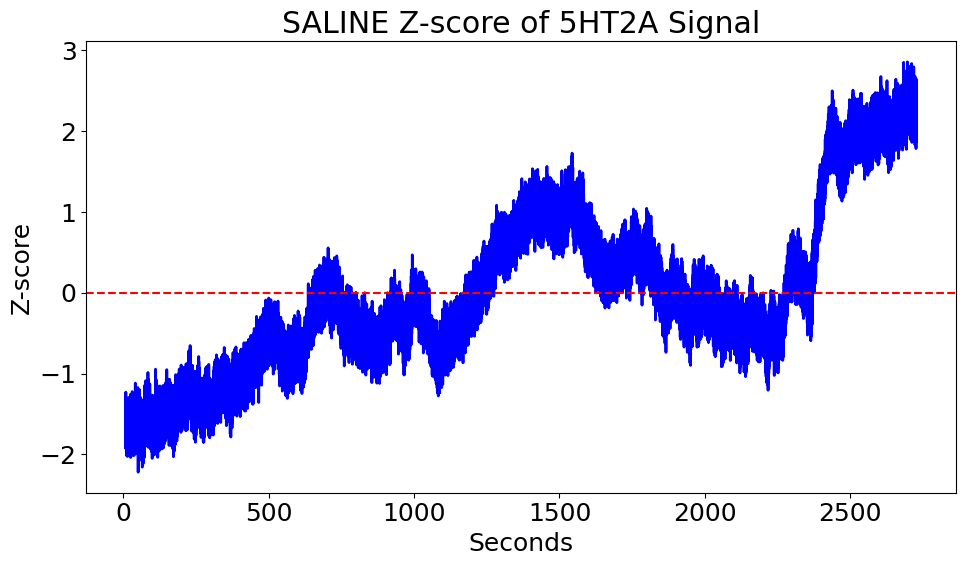

[   8.0009624     8.00194544    8.00292848 ... 2728.09913008 2728.10011312
 2728.10109616]


In [ ]:


# Subtract the ISOS signal from the serotonin signal
corrected_signal = delF - saline.streams[ISOS].data

# Define experiment start time and baseline end time
start_time_str = '1:30:14pm'
bline_end_str = '2:15:43pm'

# Parse the time strings without date
start_time = datetime.strptime(start_time_str, '%I:%M:%S%p')
bline_end_time = datetime.strptime(bline_end_str, '%I:%M:%S%p')

# Convert baseline end time to seconds relative to start time
bline_end_sec = (bline_end_time - start_time).total_seconds()

# Prepare the time axis for serotonin data
npts = len(delF)
time_x = np.linspace(1, npts, npts) / saline.streams[serotonin].fs
# Artifact removal
t = 8
inds = np.where(time_x > t)
ind = inds[0][0]
time_x = time_x[ind:]  # go from ind to final index
corrected_signal = corrected_signal[ind:]


# # Calculate the z-score
#zscore_signal = zscore(corrected_signal)

# Correct baseline index for trimmed data
baseline_end_idx = np.where(time_x > (bline_end_sec - t))[0][0]
baseline_mean = np.mean(corrected_signal[:baseline_end_idx])
baseline_sd = np.std(corrected_signal[:baseline_end_idx])
zscore_signal = (corrected_signal - baseline_mean) / baseline_sd
# Plot the z-score of the corrected pcb signal
fig2, ax1 = plt.subplots(figsize=(10, 6))
p2, = ax1.plot(time_x, zscore_signal, linewidth=2, color='blue', label='Z-score (serotonin - ISOS)')

# Mark the baseline with a horizontal line on the z-score plot
baseline_zscore = np.mean(zscore_signal[:baseline_end_idx])
ax1.axhline(y=baseline_zscore, color='red', linestyle='--', label='Baseline')

ax1.set_ylabel('Z-score')
ax1.set_xlabel('Seconds')
ax1.set_title('SALINE Z-score of 5HT2A Signal')

fig2.tight_layout()

plt.show()

# Create DataFrame for serotonin data
zscore_df = pd.DataFrame({'Time (s)': time_x, 'Z-score': zscore_signal})

# Save to CSV
zscore_df.to_csv('/gdrive/Shareddrives/Turi_lab/DeepLabCut/DLC_model_training/fiberphotometry/serotonin_fiberphotometry/serotonin_df.csv', index=False)
print(time_x)

In [ ]:
#think this is repetitive

# Assuming 'corrected_signal' and 'time_x' are already defined

# Define experiment start time and baseline end time
start_time_str = '1:30:14pm'
bline_end_str = '1:46:05pm'

# Parse the time strings without date
start_time = datetime.strptime(start_time_str, '%I:%M:%S%p')
bline_end_time = datetime.strptime(bline_end_str, '%I:%M:%S%p')

# Convert baseline end time to seconds relative to start time
bline_end_sec = (bline_end_time - start_time).total_seconds()

# Prepare the time axis for serotonin data
npts = len(corrected_signal)
time_x = np.linspace(1, npts, npts) / 20  # Assuming the sample rate is 20 Hz
# Artifact removal
# t = 8
# inds = np.where(time_x > t)[0][0]
#time_x = time_x[ind:]  # go from ind to final index
#corrected_signal = corrected_signal[ind:]

# Calculate the z-score
baseline_end_idx = np.where(time_x > (bline_end_sec - t))[0][0]
baseline_mean = np.mean(corrected_signal[:baseline_end_idx])
baseline_sd = np.std(corrected_signal[:baseline_end_idx])
zscore_signal = (corrected_signal - baseline_mean) / baseline_sd

# Create DataFrame for serotonin data
serotonin_df = pd.DataFrame({'Time (s)': time_x, 'Z-score': zscore_signal})

# Save to CSV
serotonin_df.to_csv('/gdrive/Shareddrives/Turi_lab/DeepLabCut/DLC_model_training/fiberphotometry/serotonin_fiberphotometry/serotonin_df.csv', index=False)

print(npts)
print(time_x)



3775542
[5.0000000e-02 1.0000000e-01 1.5000000e-01 ... 1.8877700e+05 1.8877705e+05
 1.8877710e+05]


Found Synapse note file: /gdrive/Shareddrives/Turi_lab/Data/psilocybin_project/PCB_Serotonin/drug_experiment-240625-124323/nia_4-240628-143602/Notes.txt
read from t=0s to t=2870.46s
Found Synapse note file: /gdrive/Shareddrives/Turi_lab/Data/psilocybin_project/PCB_Serotonin/drug_experiment-240625-124323/nia_4-240701-112519/Notes.txt
read from t=0s to t=3769.22s


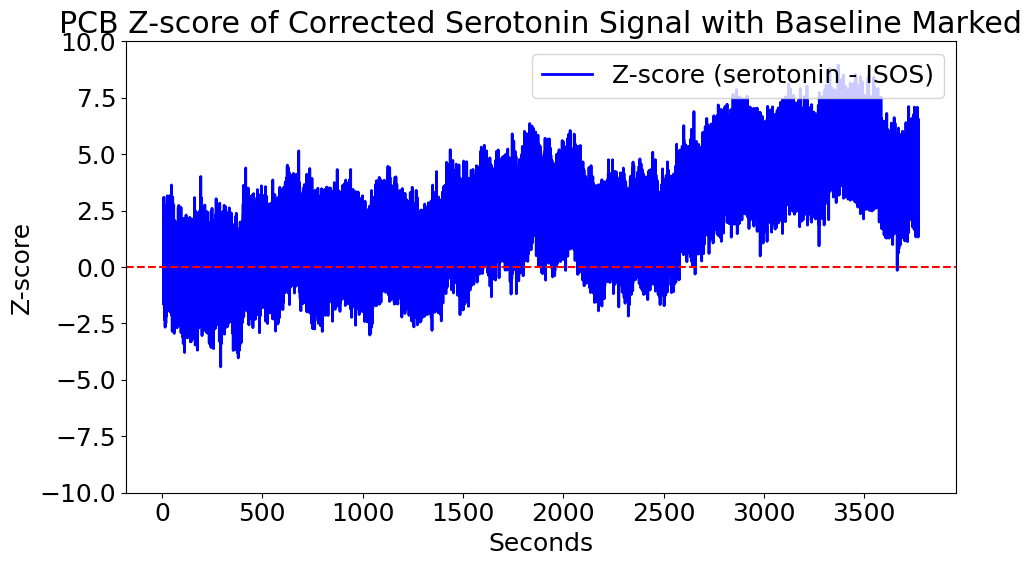

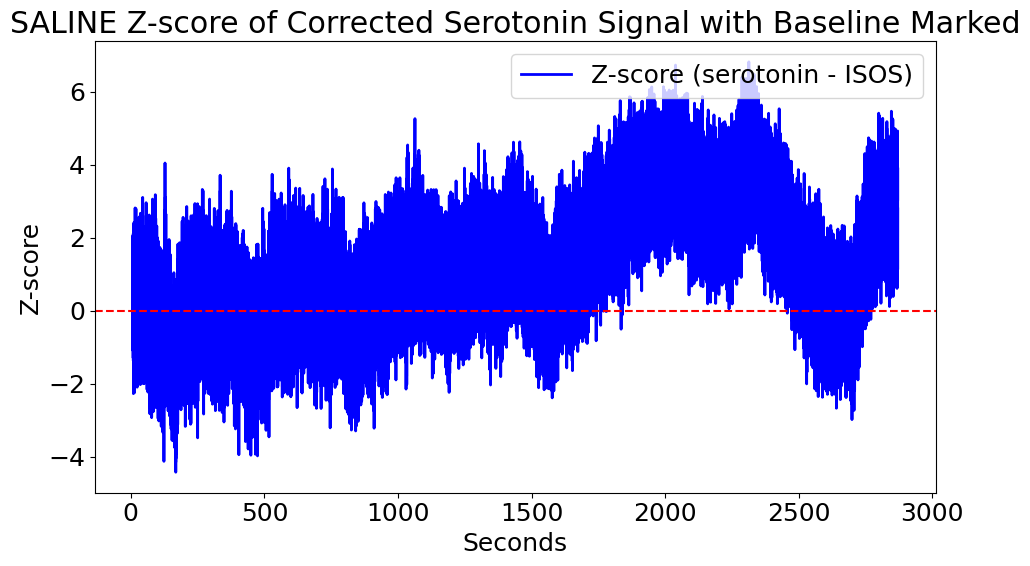

In [ ]:
#SALINE AND PCB Z SCORE

matplotlib.rcParams['font.size'] = 18  # set font size for all figures

# Path to the control data file
saline2_path = "/gdrive/Shareddrives/Turi_lab/Data/psilocybin_project/PCB_Serotonin/drug_experiment-240625-124323/nia_4-240628-143602"
pcb2_path = "/gdrive/Shareddrives/Turi_lab/Data/psilocybin_project/PCB_Serotonin/drug_experiment-240625-124323/nia_4-240701-112519"

# Read the data
saline2 = read_block(saline2_path)
pcb2 = read_block(pcb2_path)

# Define channels
serotonin = '_465A'  # serotonin channel
ISOS = '_405A'  # Isosbestic channel

# Subtract the ISOS signal from the serotonin signal
corrected_signal = pcb2.streams[serotonin].data - pcb2.streams[ISOS].data

# Define experiment start time and baseline end time
start_time_str = '11:25:23am'
bline_end_str = '11:35:25am'

# Parse the time strings without date
start_time = datetime.strptime(start_time_str, '%I:%M:%S%p')
bline_end_time = datetime.strptime(bline_end_str, '%I:%M:%S%p')

# Convert baseline end time to seconds relative to start time
bline_end_sec = (bline_end_time - start_time).total_seconds()

# Prepare the time axis for serotonin data
npts = len(pcb2.streams[serotonin].data)
time_x = np.linspace(1, npts, npts) / pcb2.streams[serotonin].fs

# Artifact removal
t = 8
inds = np.where(time_x > t)
ind = inds[0][0]
time_x = time_x[ind:]  # go from ind to final index
corrected_signal = corrected_signal[ind:]

# Correct baseline index for trimmed data
baseline_end_idx = np.where(time_x > (bline_end_sec - t))[0][0]
baseline_mean = np.mean(corrected_signal[:baseline_end_idx])
baseline_sd = np.std(corrected_signal[:baseline_end_idx])
zscore_signal = (corrected_signal - baseline_mean) / baseline_sd

# Plot the z-score of the corrected pcb signal
fig2, ax1 = plt.subplots(figsize=(10, 6))
p2, = ax1.plot(time_x, zscore_signal, linewidth=2, color='blue', label='Z-score (serotonin - ISOS)')

# Mark the baseline with a horizontal line on the z-score plot
baseline_zscore = np.mean(zscore_signal[:baseline_end_idx])
ax1.axhline(y=baseline_zscore, color='red', linestyle='--', label='Baseline')

# Set consistent y-axis limits
ax1.set_ylim(-10, 10)

ax1.set_ylabel('Z-score')
ax1.set_xlabel('Seconds')
ax1.set_title('PCB Z-score of Corrected Serotonin Signal with Baseline Marked')
ax1.legend(handles=[p2], loc='upper right')
fig2.tight_layout()

plt.show()


# Subtract the ISOS signal from the serotonin signal
corrected_signal = saline2.streams[serotonin].data - saline2.streams[ISOS].data
# Define experiment start time and baseline end time
start_time_str = '2:36:05pm'
bline_end_str = '2:52:53pm'

# Parse the time strings without date
start_time = datetime.strptime(start_time_str, '%I:%M:%S%p')
bline_end_time = datetime.strptime(bline_end_str, '%I:%M:%S%p')

# Convert baseline end time to seconds relative to start time
bline_end_sec = (bline_end_time - start_time).total_seconds()

# Prepare the time axis for serotonin data
npts = len(saline2.streams[serotonin].data)
time_x = np.linspace(1, npts, npts) / saline2.streams[serotonin].fs
# Artifact removal
t = 8
inds = np.where(time_x > t)
ind = inds[0][0]
time_x = time_x[ind:]  # go from ind to final index
corrected_signal = corrected_signal[ind:]

# # Calculate the z-score
# zscore_signal = zscore(corrected_signal)

# Correct baseline index for trimmed data
baseline_end_idx = np.where(time_x > (bline_end_sec - t))[0][0]
baseline_mean = np.mean(corrected_signal[:baseline_end_idx])
baseline_sd = np.std(corrected_signal[:baseline_end_idx])
zscore_signal = (corrected_signal - baseline_mean) / baseline_sd
# Plot the z-score of the corrected pcb signal
fig2, ax1 = plt.subplots(figsize=(10, 6))
p2, = ax1.plot(time_x, zscore_signal, linewidth=2, color='blue', label='Z-score (serotonin - ISOS)')

# Mark the baseline with a horizontal line on the z-score plot
baseline_zscore = np.mean(zscore_signal[:baseline_end_idx])
ax1.axhline(y=baseline_zscore, color='red', linestyle='--', label='Baseline')

ax1.set_ylabel('Z-score')
ax1.set_xlabel('Seconds')
ax1.set_title('SALINE Z-score of Corrected Serotonin Signal with Baseline Marked')
ax1.legend(handles=[p2], loc='upper right')
fig2.tight_layout()

plt.show()

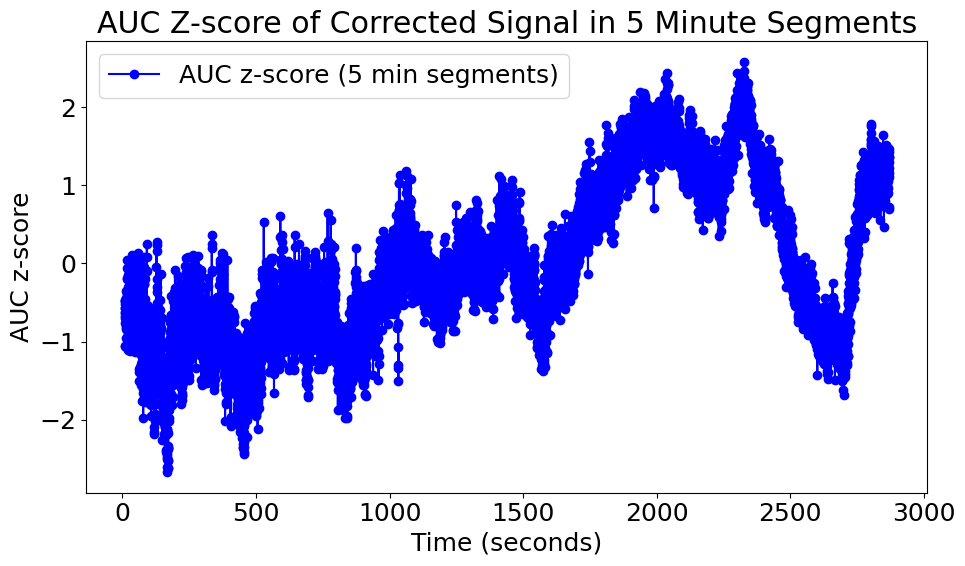

In [ ]:
#area under the curve (IN THE WORKS)

# Assuming time_x and corrected_signal are defined and available from your earlier data
# For example:
# time_x = np.array([...])  # time data in seconds
# corrected_signal = np.array([...])  # corrected signal data

# Calculate the z-score of the corrected signal
zscore_signal = zscore(corrected_signal)

# Define the segment length (5 minutes in seconds)
segment_length = 5 * 60

# Initialize lists to store the segment AUCs and their corresponding times
segment_aucs = []
segment_times = []

# Calculate the number of segments
num_segments = len(time_x) // segment_length

# Iterate over each segment
for i in range(num_segments):
    start_idx = i * segment_length
    end_idx = start_idx + segment_length
    if end_idx > len(time_x):
        end_idx = len(time_x)

    # Extract the segment of the signal and time
    segment_signal = zscore_signal[start_idx:end_idx]
    segment_time = time_x[start_idx:end_idx]

    # Calculate the AUC using Simpson's rule
    auc = simps(segment_signal, segment_time)
    segment_aucs.append(auc)

    # Calculate the midpoint of the segment for plotting
    segment_midpoint = (segment_time[0] + segment_time[-1]) / 2
    segment_times.append(segment_midpoint)

# Calculate the z-score of the segment AUCs
segment_aucs_zscore = zscore(segment_aucs)

# Plot the z-score of the segment AUCs
plt.figure(figsize=(10, 6))
plt.plot(segment_times, segment_aucs_zscore, marker='o', linestyle='-', color='blue', label='AUC z-score (5 min segments)')
plt.xlabel('Time (seconds)')
plt.ylabel('AUC z-score')
plt.title('AUC Z-score of Corrected Signal in 5 Minute Segments')
plt.legend()
plt.tight_layout()
plt.show()
